# Fine Grained Aspect Extraction and Clustering

This notebook examines extracting aspects using Spacy and rules-based conditions

* Section 1: Import libraries and data
* Section 2: Extract Nouns
* Section 3: Toy Data Example with Spacy Dependency Parser
* Section 4: Using the Dependency Parser on the Full text to Extract Aspects
* Section 5: KMeans Clustering algorithm to extract fine-grained aspects

# NOTEBOOK NOT COMPLETE

# Section 1: Import libraries and data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import contractions
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import spacy
from spacy import displacy
import gensim
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
#nltk.download('averaged_perceptron_tagger')
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
df = pd.read_csv("explodedsentencescleaned.csv",index_col = 0)

In [31]:
df.shape

(59956, 8)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59956 entries, 0 to 10406
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   OrigInd    59956 non-null  int64 
 1   Category   59956 non-null  object
 2   Town       59956 non-null  object
 3   Rating     59956 non-null  int64 
 4   all_text   59956 non-null  object
 5   sentences  59956 non-null  object
 6   len        59956 non-null  int64 
 7   cleaned    59831 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.1+ MB


In [33]:
# Drop null values
df.dropna(subset=['cleaned'],inplace = True)

In [34]:
#df = df.drop(columns = ["cleaned"],axis = 1)
df.columns = ["OrigInd","Category","Town","Rating","review","sentences","len","cleaned"]
#df["sentences"] = df["sentences"].apply(lambda x: x.strip("\n\t ").lower())

# Section 3: Parts of Speech using Spacy on Toy Data

In [35]:
# Example texts
doc1 = "The food was just about edible"
doc2 = 'the parking was a problem'

In [36]:
# Load spacy and create document
nlp = spacy.load('en_core_web_sm')
doc1= nlp(doc1)
doc2 = nlp(doc2)

In [37]:
# For each word define universal parts of speech, lemma, detailed parts of speech, dependency, whether it is alpha numeric or a stopword
def spac(doc):
    for token in doc:
        print(token.text,token.lemma_, token.pos_, token.tag_, token.dep_,
              token.shape_, token.is_alpha, token.is_stop)

In [38]:
# Run for document 1
spac(doc1)

The the DET DT det Xxx True True
food food NOUN NN nsubj xxxx True False
was be AUX VBD ROOT xxx True True
just just ADV RB advmod xxxx True True
about about ADP IN prep xxxx True True
edible edible ADJ JJ acomp xxxx True False


In [39]:
# Run for document 2
spac(doc1)

The the DET DT det Xxx True True
food food NOUN NN nsubj xxxx True False
was be AUX VBD ROOT xxx True True
just just ADV RB advmod xxxx True True
about about ADP IN prep xxxx True True
edible edible ADJ JJ acomp xxxx True False


In [40]:
# Render dependencies in notebook - uncomment to run each
# displacy.render(doc1, style='dep', jupyter=True)
displacy.render(doc1, style='dep', jupyter=True)

In [41]:
# Render dependencies in browser, uncomment to run and then visit localhost:5000 to see the graph
#displacy.serve(doc, style='dep')

# Section 4: Full dataset Aspect Extraction

Code from https://github.com/ishikaarora/Aspect-Sentiment-Analysis-on-Amazon-Reviews/blob/master/src/models/aspect_extraction.py

## Aspect Extraction

In [42]:
#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_lg')
sent = SentimentIntensityAnalyzer()

In [43]:
# Extraction function, adapted from Joshi et al.(2018)

def apply_extraction(x):
    
    category = "Category"
    town = "Town"
    score = "Score"
    review_index = "OrigInd"
    doc= nlp(x)
    pron = ['it','this','they','these']
    sent = SentimentIntensityAnalyzer()
    
            
    # Note A is the aspect word token and M is the modifier
    
    # Number 1 - Relationship of amod between M as child of A
    list_1 = []
    for token in doc:
        A = ""
        M = ""
        if token.dep_ == "amod" and token.dep_ and not token.is_stop:
            M = token.text
            A = token.head.text
            
            # modifier of adjective for example 'very tasty food'
            M_children = token.children
            for child_m in M_children:
                if(child_m.dep_ == "advmod"):
                    M_1 = child_m.text
                    M = M_1 + " " + M
                    break

            # adjective negation, as determinant of a noun for example 'no friendly waiters'
            A_children = token.head.children
            for child_a in A_children:
                if(child_a.dep_ == "det" and child_a.text == 'no'):
                    neg_prefix = 'not'
                    M = neg_prefix + " " + M
                    break

            if(A != "" and M != ""):
                list_1.append((A, M,sent.polarity_scores(token.text)['compound'],1))

    # Number 2 - A is a child of a word with relationship of nsubj, and M is a child of this word with relationship of dobj
    # Assumes - A verb will have only one NSUBJ and DOBJ

    list_2 = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not token.is_stop):
                A = child.text
                
            if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
                M = child.text
                
            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != ""):
            M = neg_prefix + " " + M

        if(A != "" and M != ""):
            list_2.append((A, M,sent.polarity_scores(M)['compound'],2))


    # Number 3 - A is a child of a word with relationship of nsubj and M is a child of this word with relationship of acomp,
    # eg The choices on the menu could be better
    # Assumes - A verb will have only one NSUBJ and DOBJ
    
    list_3 = []

    for token in doc:

        children = token.children
        A = ""
        M = ""
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                
            if(child.dep_ == "acomp" and not child.is_stop):
                M = child.text

            # example - 'menu could have been better' -> (menu, not better)
            if(child.dep_ == "aux" and child.tag_ == "MD"):
                neg_prefix = "not"
                add_neg_pfx = True

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != ""):
            M = neg_prefix + " " + M
                
        if(A != "" and M != ""):
            list_3.append((A, M, sent.polarity_scores(M)['compound'],3))

    # Number 4 - A is a child of a word with relationship of nsubjpass, and M is a child of this word with relationship of advmod
    # Assumes - A verb will have only one NSUBJ and DOBJ
    
    list_4 = []
    for token in doc:


        children = token.children
        A = ""
        M = ""
        add_neg_pfx = False
        for child in children :
            if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                A = child.text
               
            if(child.dep_ == "advmod" and not child.is_stop):
                M = child.text
                M_children = child.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + child.text
                        break
                
            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != ""):
            M = neg_prefix + " " + M

        if(A != "" and M != ""):
            list_4.append((A, M,sent.polarity_scores(M)['compound'],4)) 


    # Number 5 - A is a child of M with relationship of nsubj, and M has a child with a relationship of Copula
    # Assumption - A verb will have only one NSUBJ and DOBJ

    list_5 = []
    for token in doc:
        children = token.children
        A = ""
        buf_var = ""
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                
            if(child.dep_ == "cop" and not child.is_stop):
                buf_var = child.text
                
        if(A != "" and buf_var != ""):
            list_5.append((A, token.text,sent.polarity_scores(token.text)['compound'],5))


    # Number 6 - Interjections such as 'great', 'ok'
    
    list_6 = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        if(token.pos_ == "INTJ" and not token.is_stop):
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    M = token.text
                    
        if(A != "" and M != ""):
            list_6.append((A, M,sent.polarity_scores(M)['compound'],6))


    # Number 7 - Links between a verb and complement eg. 'this is awful' to render as 'this, 'awful'
    
    list_7 = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "attr") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != ""):
            M = neg_prefix + " " + M

        if(A != "" and M != ""):
            list_7.append((A, M,sent.polarity_scores(M)['compound'],7))



    aspects = []

    aspects = list_1 + list_2 + list_3 + list_4 + list_5 + list_6 + list_7

    # replace all instances of "it", "this" and "they" with "category"
    aspects = [(A,M,P,r) if A not in pron else ("product",M,P,r) for A,M,P,r in aspects ]
    
    dic = {"aspect_pairs" : aspects}

    return dic

In [44]:
# UNCOMMENT TO RUN
df["Aspects"] = df["cleaned"].apply(lambda x: apply_extraction(x))
df.to_csv("ExtractedAspects.csv")

## Extract Top Aspect Words from Aspects Extracted by Function

In [47]:
df["Aspects"] = df["Aspects"].apply(lambda x: eval(x))

In [48]:
def extract_aspect(x):
    elements = [item for sublist in x.values() for item in sublist]
    aspect = [x[0] for x in elements]
    #aspect = ' '.join(aspect)
    return aspect

In [49]:
def extract_sentiment(x):
    x = [item for sublist in x.values() for item in sublist]
    x = [i[2] for i in x]
    return x

In [50]:
#def extract_nouns(x):
    #nouns = []
   # doc = nlp(x)
    #for token in doc:
        #if token.pos_ == "NOUN":
          #  nouns.append(token)
   # return nouns

In [51]:
#def extract_noun_adj(x):
    #noun = []
    #adj = []
    #elements = [item for sublist in x.values() for item in sublist]
    #n = [i[0] for i in elements]
    #n = ' '.join(n)
    #noun.append(n)
    #a = [i[1] for i in elements]
    #a = ' '.join(a)
    #adj.append(a)
    #return noun, adj

In [52]:
# Run functions
df["Aspect_words"] = df["Aspects"].apply(lambda x: extract_aspect(x))
df["Sentiment"] = df["Aspects"].apply(lambda x: extract_sentiment(x))
#df["Nouns"] = df["review"].apply(lambda x: extract_nouns(x))
#df["NounAdj"] = df["Aspects"].apply(lambda x: extract_noun_adj(x))

In [53]:
df.sample(5)

,Unnamed: 0,OrigInd,Category,Town,Rating,review,sentences,len,cleaned,Aspects,Aspect_words,Sentiment
55396,9441,9441,Attractions,Arundel,3,"Yes to the castle, NO to the restaurant The c...",The grounds are also beautiful and a must.,42,ground also beautiful must,"{'aspect_pairs': [('ground', 'also beautiful',...",[ground],[0.5994]
40868,6577,6577,Food,Bognor,5,Great pub Popped in with elderly Mum on very h...,"which they gave with biscuits, staff were so f...",71,gave biscuit staff friendly lovely atmosphere,"{'aspect_pairs': [('atmosphere', 'friendly', 0...","[atmosphere, atmosphere]","[0.4939, 0.5859]"
14900,1764,1764,Accommodation,Bognor,5,Fab Hotel Well this hotel is a touch dated and...,Fab Hotel Well this hotel is a touch dated and...,95,fab hotel well hotel touch dated stayed majori...,"{'aspect_pairs': [('hotel', 'fab', 0.4588, 1),...","[hotel, guest, touch]","[0.4588, 0.0, 0.0]"
24728,3456,3456,Food,Littlehampton,4,"Meal for two We had a lovely meal, was served ...","Food was delicious, no problems.",32,food delicious problem,"{'aspect_pairs': [('problem', 'delicious', 0.5...",[problem],[0.5719]
34528,5306,5306,Food,Littlehampton,1,Such poor food and service Came for what looke...,"Cup of tea not made or served, to top it off o...",91,cup tea not made served top sandwich given wro...,"{'aspect_pairs': [('person', 'wrong', -0.4767,...",[person],[-0.4767]


In [54]:
# Explode the 'aspects' and 'sentiment' columns into separate rows
df_explode = df.apply(lambda x: x.explode() if x.name in ['Aspect_words','Sentiment'] else x)
df_explode.shape

(111655, 12)

### Cleaning

In [55]:
# Rows with no aspects extracted
no_aspects = df_explode[df_explode["Aspect_words"].isnull()]
#no_aspects.to_csv("no_aspects_extracted.csv")
no_aspects.shape

(16504, 12)

In [56]:
# Create new dataframe with just the results with extracted aspects
aspects = df_explode[~df_explode["Aspect_words"].isnull()]
aspects.shape

(95151, 12)

In [57]:
# Look at head
aspects.head()

,Unnamed: 0,OrigInd,Category,Town,Rating,review,sentences,len,cleaned,Aspects,Aspect_words,Sentiment
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"{'aspect_pairs': [('shame', 'nice', 0.4215, 1)...",shame,0.4215
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"{'aspect_pairs': [('shame', 'nice', 0.4215, 1)...",kid,0.0
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"{'aspect_pairs': [('shame', 'nice', 0.4215, 1)...",kid,0.0
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"{'aspect_pairs': [('shame', 'nice', 0.4215, 1)...",treat,0.0
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"{'aspect_pairs': [('shame', 'nice', 0.4215, 1)...",accommodation,0.0


In [58]:
# Split into categories
aspects_accom = aspects[aspects["Category"]=="Accommodation"]
aspects_food = aspects[aspects["Category"] =="Food"]
aspects_attract = aspects[aspects["Category"] == "Attractions"]

In [59]:
# Set Sentiment score to float
aspects["Sentiment"] = aspects["Sentiment"].astype('float')

In [60]:
# Create dataframes of aspects, counts and average sentiment values
df_aspect_words = pd.DataFrame(aspects.groupby(['Aspect_words','Category',"Sentiment"],as_index = False)["Town"].count())
df_aspect_words.columns = ["Aspect","Category","Sentiment","Count"]
df_aspect_words.sort_values("Count",ascending = False).head(10)

,Aspect,Category,Sentiment,Count
8135,food,Food,0.0000,1142
17340,room,Accommodation,0.0000,917
19605,staff,Food,0.0000,807
16951,restaurant,Food,0.0000,630
18229,service,Food,0.0000,572
19625,staff,Food,0.4939,555
12660,menu,Food,0.0000,528
12457,meal,Food,0.0000,496
20563,table,Food,0.0000,451
8150,food,Food,0.4404,428


In [61]:
# Number of unique words in Aspects
df_aspect_words["Aspect"].nunique()

5541

In [62]:
# Dataframe of unique words
unique = pd.DataFrame(df_aspect_words["Aspect"].unique())

In [63]:
accom = df_aspect_words[df_aspect_words["Category"] == "Accommodation"].groupby(["Aspect"],as_index = False)["Sentiment"].mean()
food = df_aspect_words[df_aspect_words["Category"] == "Food"].groupby(["Aspect"],as_index = False)["Sentiment"].mean()
attract = df_aspect_words[df_aspect_words["Category"] == "Attractions"].groupby(["Aspect"],as_index = False)["Sentiment"].mean()

In [226]:
accom.sample(5)

,Aspect,Sentiment
1243,gulls,0.00000
1752,nights.i,0.00000
1849,paint,-0.10455
2838,video,0.00000
46,accidents,0.63690


In [2710]:
# Send aspects dataframe to csv
#unique.to_csv("ExtractedAspects.csv")

# Section 5: Word Embeddings

### Create unique word lists and spacy word embeddings for each category

In [227]:
from sklearn import cluster 
from collections import defaultdict

In [228]:
# Collect unique aspects for each category
unique_accom = pd.DataFrame(accom["Aspect"].unique())
unique_food = pd.DataFrame(food["Aspect"].unique())
unique_attract = pd.DataFrame(attract["Aspect"].unique())

In [229]:
# Put to a list
unique_accom_aspects = list(unique_accom[0])
unique_food_aspects = list(unique_food[0])
unique_attract_aspects = list(unique_attract[0])

In [230]:
#Length of unique aspects lists
print(len(unique_accom_aspects))
print(len(unique_food_aspects))
print(len(unique_attract_aspects))

2981
3629
1707


In [231]:
# Vectorize with Spacy - 300 character vectors from the large spacy english dictionary
def vector_words(unique_aspects):
    asp_vectors = []
    for aspect in unique_aspects:
        token = nlp(aspect)
        asp_vectors.append(token.vector)
    return asp_vectors

In [232]:
# Run function to create vectors
vect_accom = vector_words(unique_accom_aspects)
vect_food = vector_words(unique_food_aspects)
vect_attract = vector_words(unique_attract_aspects)

### Find the optimum number of clusters for each category

In [233]:
# Function to try different values for number of clusters and check the elbow graph for maximum curvature
def elbow_func(dtm):
    Sum_of_squared_distances = []
    scores = []
    n_clusters = range(2,26,1)
    for n in n_clusters:
        km = KMeans(n_clusters = n)
        km_fit = km.fit(dtm)
        labels = km.labels_
        Sum_of_squared_distances.append(km.inertia_)
        preds = km.predict(dtm)
        centers = km.cluster_centers_
        score = silhouette_score(dtm, preds)
        scores.append(score)
              
    return Sum_of_squared_distances, scores

In [239]:
# Elbow graph to find optimum number of topics
def plot_elbow(data,name,vline_marker):
    K = range(2,26,1)
    plt.plot(K, data)
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k:' + name)
    y = data
    x = range(1, len(y)+1)
    # note sensitivity parameter (S) is how many flat points in the data before declaring a knee
    #kn = KneeLocator(x, y, curve='convex', direction='decreasing') 
    #print("Knee locator value:",kn.knee)
    #plt.vlines(kn.knee,plt.ylim()[0], plt.ylim()[1], linestyles='dashed',linewidth = 1, color = "red")
    plt.vlines(vline_marker,plt.ylim()[0], plt.ylim()[1], linestyles='dashed',linewidth = 1, color = "grey")
    plt.show()

### Accommodation

In [235]:
# Run function 1
elbow,scores = elbow_func(vect_accom)

In [237]:
# Print the inertia scores for cluster numbers
num = list(range(2,26,1))
pd.DataFrame({"Clusters":num,"Scores":scores}).head(10)

,Clusters,Scores
0,2,0.048283
1,3,0.046481
2,4,0.050000
3,5,0.039314
4,6,0.040846
5,7,0.040801
6,8,0.038850
7,9,0.037708
8,10,0.038008
9,11,-0.026058


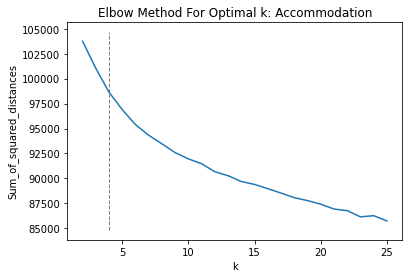

In [240]:
# Run plot function
plot_elbow(elbow," Accommodation",4)

Highest inertia score is at 4 clusters

### Food

In [241]:
elbow,scores = elbow_func(vect_food)

In [242]:
num = list(range(2,26,1))
pd.DataFrame({"Clusters":num,"Scores":scores}).head(10)

,Clusters,Scores
0,2,0.099849
1,3,0.057975
2,4,0.054059
3,5,0.053144
4,6,0.051498
5,7,0.048695
6,8,0.046987
7,9,-0.019522
8,10,0.039475
9,11,-0.014569


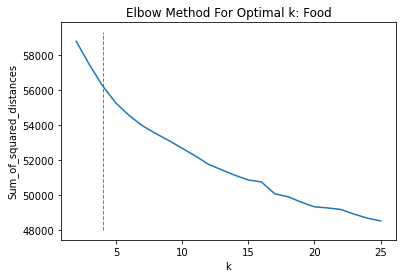

In [248]:
plot_elbow(elbow," Food",4)

Inertia score highest at 6 topics

### Attractions

In [244]:
elbow,scores = elbow_func(vect_attract)

In [245]:
num = list(range(2,26,1))
pd.DataFrame({"Clusters":num,"Scores":scores}).head(10)

,Clusters,Scores
0,2,0.042619
1,3,0.044036
2,4,0.049421
3,5,0.028499
4,6,0.029093
5,7,0.030303
6,8,0.032242
7,9,0.032624
8,10,0.027128
9,11,0.030480


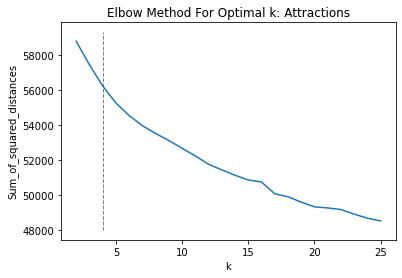

In [246]:
plot_elbow(elbow," Attractions",4)

### K Means with Cluster Numbers

In [247]:
# Run kmeans using the vectors
def kmean_func(vector,num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    result = kmeans.fit(vector)
    return result

In [265]:
# Run function
a = kmean_func(vect_accom,4)
f = kmean_func(vect_food,4)
at = kmean_func(vect_attract,4)

In [266]:
# Map to tag clusters
aspects_map = defaultdict(int) 
for asp in aspects:
    aspects_map[asp] += 1

In [267]:
def create_cluster_map(unique_aspects,x):
    labels = x.labels_
    asp_to_cluster_map = dict(zip(unique_aspects,labels))
    return asp_to_cluster_map

In [268]:
cluster_map_accom = create_cluster_map(unique_accom_aspects,a)
cluster_map_food = create_cluster_map(unique_food_aspects,f)
cluster_map_attract = create_cluster_map(unique_attract_aspects,at)

In [264]:
print(cluster_map_accom)
#print(cluster_map_food)
#print(cluster_map_attract)

{'\n': 3, '\n\n': 3, '\n ': 3, ' ': 3, '%': 2, '-fashioned': 3, '-well': 3, '.needs': 3, '.this': 3, '1': 2, '10': 2, '10,or': 3, '100': 2, '12': 2, '12th': 2, '150': 2, '18month': 3, '2': 2, '20': 2, '22nd': 2, '246': 3, '28th': 2, '30': 2, '30mins': 3, '31st': 2, '4': 2, '40': 2, '40s/50s': 3, '4yo': 3, '5': 2, '5.30/6pm': 3, '5.95': 3, '500': 2, '5th': 2, '60': 2, '70s': 2, '80': 2, '911': 2, 'a272': 3, 'a29': 3, 'abbie': 3, 'about': 2, 'abuse': 2, 'accents': 1, 'access': 2, 'accident': 2, 'accidents': 2, 'accomation': 3, 'accommadation': 3, 'accommodation': 1, 'accomodation': 3, 'accompaniment': 0, 'accounts': 2, 'acess': 3, 'achievement': 2, 'acomodation': 3, 'acoustics': 1, 'acrobats': 3, 'act': 2, 'action': 2, 'actions': 2, 'activities': 2, 'activity': 2, 'actor': 2, 'actresses': 2, 'acts': 2, 'actvities': 3, 'adaptor': 1, 'addition': 2, 'additions': 2, 'adult': 2, 'adults': 2, 'adventure': 2, 'advert': 3, 'advertising': 2, 'advice': 2, 'affair': 2, 'affection': 2, 'africa': 3, 

In [269]:
len(cluster_map_accom)

2981

In [270]:
# Cluster aspects
def cluster(n,name):
    cluster = [k for k,v in asp_to_cluster_map.items() if float(v) ==n]
    return cluster 

### Accommodation

In [271]:
# Apply cluster function for accommodation
name = cluster_map_accom
cluster_list = []
for i in range(4):
    clusters= cluster(i,name)
    cluster_list.append(clusters)

NameError: name 'asp_to_cluster_map' is not defined

In [259]:
cluster1 = cluster_list[0]
cluster2 = cluster_list[1]
cluster3 = cluster_list[2]
cluster4 = cluster_list[3]
cluster5 = cluster_list[4]

IndexError: list index out of range

In [2602]:
# Apply topic to each line based on word being in each cluster
conditions = [aspects_accom["Result"].isin(cluster1),aspects_accom["Result"].isin(cluster2),aspects_accom["Result"].isin(cluster3),
             aspects_accom["Result"].isin(cluster4),aspects_accom["Result"].isin(cluster5)]

values = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

aspects_accom["Topic"] = np.select(conditions,values)

In [2604]:
aspects_accom.head()

,OrigID,Town,Category,Score,Review,Aspects,Result,Sentiment,Topic
0,246,Bognor,Accommodation,0,"Central B & B We had room 6, excellent view, w...","{'aspect_pairs': [('view', 'excellent', 0.5719...",view,0.5719,Topic3
1,246,Bognor,Accommodation,0,"There are 8 rooms, the 2 top floor ones are si...","{'aspect_pairs': [('ones', 'singles', 0.0, 7)]}",ones,0.0000,Topic1
2,246,Bognor,Accommodation,0,We were told that most of the occupancy was gi...,"{'aspect_pairs': [('pool', 'new', 0.0, 1)]}",pool,0.0000,Topic4
3,246,Bognor,Accommodation,0,"Parking could be a problem, but Alison gave us...","{'aspect_pairs': [('parking', 'problem', -0.40...",parking,-0.4019,Topic4
4,246,Bognor,Accommodation,0,"Very good breakfast, but when did hash browns ...","{'aspect_pairs': [('breakfast', 'very good', 0...",breakfast,0.4404,Topic2


In [2623]:
aspects_accom[aspects_accom["Topic"] == "Topic5"].sample(5)

,OrigID,Town,Category,Score,Review,Aspects,Result,Sentiment,Topic
605,6,Littlehampton,Accommodation,0,The bed was so comfortable and the breakfast w...,"{'aspect_pairs': [('drinker', 'non', 0.0, 1), ...",drinker,0.0000,Topic5
1779,206,Littlehampton,Accommodation,0,Had one of the best meals I have had in a long...,"{'aspect_pairs': [('mealshave', 'best', 0.6369...",mealshave,0.6369,Topic5
1448,141,Bognor,Accommodation,0,"In particular, we enjoyed it when the fairgrou...","{'aspect_pairs': [('in', 'particular', 0.0, 1)...",fairground,0.0000,Topic5
2173,10,Bognor,Accommodation,0,Good onsite parking; great location on the sea...,"{'aspect_pairs': [('location', 'good', 0.4404,...",howeverdid,0.2023,Topic5
1880,329,Bognor,Accommodation,0,"The waterpark is brilliant, we've done lots of...","{'aspect_pairs': [('waterpark', 'brilliant', 0...",waterpark,0.5859,Topic5


In [2627]:
# Send aspects dataframe to csv
aspects_accom.to_csv("TopicsAccom.csv")

### Food

In [2327]:
# Apply cluster function for accommodation
cluster1 = cluster(cluster_map_food,0)
cluster2 = cluster(cluster_map_food,1)
cluster3 = cluster(cluster_map_food,2)
cluster4 = cluster(cluster_map_food,3)
cluster5 = cluster(cluster_map_food,4)
cluster6 = cluster(cluster_map_food,5)

In [2328]:
# Apply topic to each line based on word being in each cluster
conditions = [aspects_food["Result"].isin(cluster1),aspects_food["Result"].isin(cluster2),aspects_food["Result"].isin(cluster3),
             aspects_food["Result"].isin(cluster4),aspects_food["Result"].isin(cluster5),aspects_food["Result"].isin(cluster6)]

values = ["Topic1","Topic2","Topic3","Topic4","Topic5","Topic6"]

aspects_food["Topic"] = np.select(conditions,values)

In [2329]:
aspects_food.head()

,OrigID,Town,Category,Score,Review,Aspects,Result,Sentiment,Topic
3110,1100,Littlehampton,Food,0,Very nice pub fare and ale This is a franchise...,"{'aspect_pairs': [('fare', 'very nice', 0.4215...",fare,0.4215,Topic2
3111,1100,Littlehampton,Food,0,"Bar and serving staff were extremely pleasant,...","{'aspect_pairs': [('staff', 'serving', 0.0, 1)...",staff,0.0000,Topic3
3111,1100,Littlehampton,Food,0,"Bar and serving staff were extremely pleasant,...","{'aspect_pairs': [('staff', 'serving', 0.0, 1)...",restaurant,0.5106,Topic4
3111,1100,Littlehampton,Food,0,"Bar and serving staff were extremely pleasant,...","{'aspect_pairs': [('staff', 'serving', 0.0, 1)...",bar,0.4019,Topic4
3111,1100,Littlehampton,Food,0,"Bar and serving staff were extremely pleasant,...","{'aspect_pairs': [('staff', 'serving', 0.0, 1)...",bar,0.0000,Topic4


### Attractions

In [ ]:
# Apply cluster function for accommodation
cluster1 = cluster(cluster_map_attract,0)
cluster2 = cluster(cluster_map_attract,1)
cluster3 = cluster(cluster_map_attract,2)

In [2330]:
# Apply topic to each line based on word being in each cluster
conditions = [aspects_attract["Result"].isin(cluster1),aspects_attract["Result"].isin(cluster2),aspects_attract["Result"].isin(cluster3)]
             
values = ["Topic1","Topic2","Topic3"]

aspects_attract["Topic"] = np.select(conditions,values)

In [2331]:
aspects_attract.head()

,OrigID,Town,Category,Score,Review,Aspects,Result,Sentiment,Topic
9720,53,Arundel,Attractions,0,Very good - Although a little let down by one ...,"{'aspect_pairs': [('let', 'little', 0.0, 1)]}",let,0.0000,Topic1
9721,53,Arundel,Attractions,0,The tractor ride is lovely and the set up is g...,"{'aspect_pairs': [('ride', 'lovely', 0.5859, 3...",ride,0.5859,Topic1
9721,53,Arundel,Attractions,0,The tractor ride is lovely and the set up is g...,"{'aspect_pairs': [('ride', 'lovely', 0.5859, 3...",set,0.6249,Topic3
9724,53,Arundel,Attractions,0,The volunteers are very good however left a li...,"{'aspect_pairs': [('chap', 'young', 0.0, 1), (...",chap,0.0000,Topic1
9724,53,Arundel,Attractions,0,The volunteers are very good however left a li...,"{'aspect_pairs': [('chap', 'young', 0.0, 1), (...",volunteers,0.4404,Topic3


In [2546]:
# Send aspects dataframe to csv
aspects_attract.to_csv("TopicsAccom.csv")

In [1801]:
# Define model - a window of 10 either side or 20 context words seemed to work best
model1 = Word2Vec(df_new["Processed"],size = 100, window = 10, min_count = 2, sample = 0.001)

In [1802]:
# Get most similar words to 'room', the most common aspect
a = model1.wv.most_similar(positive = ['room'],topn = 20)
a

[('bathroom', 0.999945342540741),
 ('bed', 0.9999423027038574),
 ('around', 0.9999335408210754),
 ('shower', 0.9999334216117859),
 ('see', 0.9999322891235352),
 ('however', 0.9999309778213501),
 ('toilet', 0.9999284148216248),
 ('full', 0.9999262094497681),
 ('old', 0.999925434589386),
 ('floor', 0.999923586845398),
 ('door', 0.9999232888221741),
 ('guest', 0.9999220371246338),
 ('owner', 0.9999217987060547),
 ('beach', 0.9999216794967651),
 ('area', 0.9999210238456726),
 ('child', 0.9999207258224487),
 ('need', 0.9999202489852905),
 ('little', 0.9999200105667114),
 ('also', 0.9999188780784607),
 ('lot', 0.9999185800552368)]

In [1803]:
# index of most frequent words
print(model1.wv.index2word,end = "")

['not', 'food', 'good', 'would', 'staff', 'service', 'great', 'one', 'room', 'meal', 'restaurant', 'lovely', 'table', 'back', 'place', 'could', 'friendly', 'really', 'like', 'nice', 'well', 'go', 'night', 'menu', 'get', 'lunch', 'drink', 'hotel', 'visit', 'breakfast', 'le', 'family', 'order', 'went', 'also', 'chip', 'excellent', 'told', 'pub', 'ordered', 'asked', 'even', 'arrived', 'came', 'area', 'said', 'cooked', 'never', 'stay', 'fish', 'poor', 'evening', 'first', 'much', 'two', 'always', 'bar', 'made', 'busy', 'off', 'experience', 'need', 'main', 'going', 'got', 'people', 'left', 'minute', 'little', 'eat', 'clean', 'last', 'cold', 'recommend', 'disappointed', 'served', 'took', 'small', 'dinner', 'definitely', 'wait', 'new', 'lot', 'however', 'better', 'next', 'sunday', 'come', 'friend', 'best', 'money', 'customer', 'kid', 'price', 'disappointing', 'waitress', 'booked', 'looked', 'say', 'delicious', 'hot', 'quality', 'choice', 'visited', 'chicken', 'away', 'stayed', 'see', 'roast', 

In [1804]:
word_list_room = [a_tuple[0] for a_tuple in a]

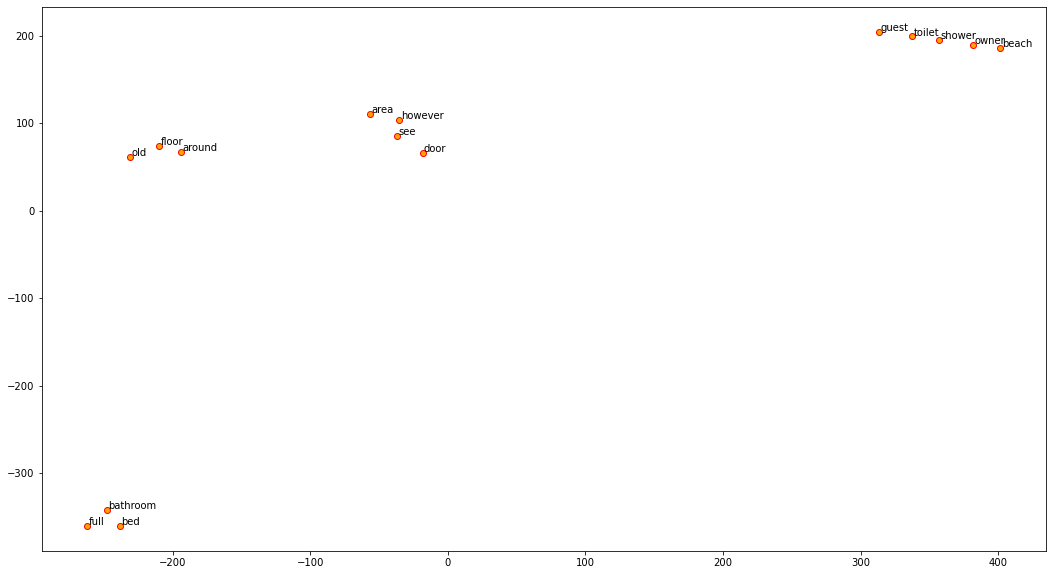

In [1807]:
# visualise a range of the most frequent words related to the word 'room' in 2 dimensions:
words = word_list_room[0:15]
wvs = model1.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18,10))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points',fontsize = 10)

The custom-trained word embeddings whilst picking up the peculiarities of the words used in the review dataset does not give particularly good word embeddings.

In [1808]:
# Function to calculate and average vector representation for each set of words comprising each document in the corpus
def vectorize_docs(docs,model):
    aspects = []
    for tokens in docs:
        vector_1 = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            average = vectors.mean(axis = 0)
            aspects.append(average)
        else:
            aspects.append(vector_1)
    return aspects

In [1810]:
documents = vectorize_docs(df_new["Processed"], model = model1)
len(documents), len(documents[0])

(10096, 100)

## Food

In [1811]:
#food = df_new[df_new["Category"] == "Food"]
#food["Processed"] = food["Review_cleaned"].apply(lambda x: gensim.utils.simple_preprocess(x))
#model2 = Word2Vec(food["Processed"],size = 100, window = 10, min_count = 2, sample = 0.001)
#documents_food = vectorize_docs(food["Processed"],model = model2)
#len(documents_food),len(documents_food[0])

## Attractions

In [1812]:
#attract = df_new[df_new["Category"] == "Attractions"]
#attract["Processed"] = attract["Review_cleaned"].apply(lambda x: gensim.utils.simple_preprocess(x))
#model3 = Word2Vec(attract["Processed"],size = 100, window = 10, min_count = 2, sample = 0.001)
#documents_attract = vectorize_docs(attract["Processed"],model = model2)
#len(documents_attract),len(documents_attract[0])

# Section 6: Clustering Using K-Means

## Find the optimum number of clusters (k)

* Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.

* Inertia: It is the sum of squared distances of samples to their closest cluster center - is between -1 and 1 with one being the best score (the higher the better)

### Accommodation

Looks to be around 6 by eye but the knee is plotted at around 3. Looking at the inertia scores they fall after zero then increase then fall again at 3 clusters with the highest at 2. This suggests that the clusters are not clearly defined in this model.

In [1816]:
# Print the inertia scores for cluster numbers
num = list(range(2,26,2))
pd.DataFrame({"Clusters":num,"Scores":scores})

,Clusters,Scores
0,2,0.535546
1,4,0.524183
2,6,0.504005
3,8,0.496607
4,10,0.483721
5,12,0.476326
6,14,0.463019
7,16,0.453869
8,18,0.443360
9,20,0.429368


In [1817]:
# Try with three clusters
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state = 0)
km.fit(documents)
centroids = km.cluster_centers_

In [1818]:
# Centroids top ten words and weights
print(model1.wv.most_similar(positive = [centroids[0]],topn = 10),"\n")
print(model1.wv.most_similar(positive = [centroids[1]],topn = 10),"\n")
print(model1.wv.most_similar(positive = [centroids[2]],topn = 10))

[('little', 0.9999722838401794), ('old', 0.9999715089797974), ('however', 0.9999714493751526), ('lot', 0.9999685883522034), ('cake', 0.9999682903289795), ('also', 0.999967634677887), ('full', 0.9999663829803467), ('found', 0.9999651312828064), ('site', 0.9999650716781616), ('although', 0.9999645948410034)] 

[('old', 0.9999799132347107), ('cake', 0.9999750852584839), ('lot', 0.9999728202819824), ('little', 0.9999727606773376), ('however', 0.9999727010726929), ('full', 0.9999710321426392), ('bit', 0.9999693632125854), ('door', 0.9999687671661377), ('around', 0.9999687075614929), ('site', 0.9999680519104004)] 

[('although', 0.9999663829803467), ('little', 0.9999634027481079), ('found', 0.999962568283081), ('however', 0.9999605417251587), ('need', 0.9999603033065796), ('also', 0.9999593496322632), ('local', 0.9999580383300781), ('lot', 0.9999572038650513), ('owner', 0.9999567270278931), ('old', 0.9999562501907349)]


In [1570]:
# print("Most representative terms per cluster using centroids")
#for i in range(3):
   # tokens_per_cluster = ""
    #most_representative = model1.wv.most_similar(positive = [km.cluster_centers_[i]],topn = 10)
    #for t in most_representative:
        #tokens_per_cluster += f"{t[0]} "
   # print(f"Cluster {i}: {tokens_per_cluster}")

### Food

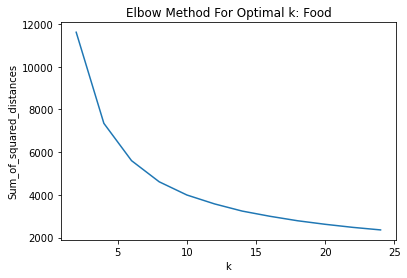

In [1476]:
# Run function
food_elbow,food_scores = elbow(documents_food)
plot_elbow(food_elbow," Food")

Again seems to be around 5 or 6

### Attractions

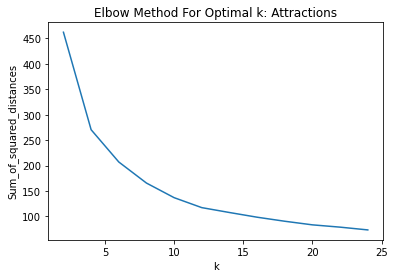

In [1477]:
# Run function
attract_elbow,attract_scores = elbow(documents_attract)
plot_elbow(attract_elbow," Attractions")

Looks to be around 4 or 5